## House Price

①Question or problem definition. 問題定義  
②Acquire training and testing data. トレインデータとテストデータの獲得  
③Wrangle, prepare, cleanse the data. 議論、前処理、クリーニング  
④Analyze, identify patterns, and explore the data. 分析、パターン識別、データ探索  
⑤Model, predict and solve the problem. モデル、予測、問題の解決  
⑥Visualize, report, and present the problem solving steps and final solution.  　　　
　　　　　　　　　　　　　　　　　　　　　　　　可視化、レポート、問題解決のステップと最後の帰結を表す  
Supply or submit the results. 結果を提出

## definition

③回帰分析  
⑥Root-Mean-Squared-Error (RMSE) 

## traindata & testdata

In [1]:
import pandas as pd
import numpy as np
import sklearn.datasets as datasets
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import pylab
from scipy.stats import skew
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline, make_pipeline
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

import warnings
warnings.simplefilter('ignore', UserWarning)

import gc
gc.enable()

#pd.options.display.max_colwidth
%matplotlib inline

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
df_train = pd.read_csv('input/train.csv')
df_test = pd.read_csv('input/test.csv')
train = df_train.copy()

df_train.head()

In [6]:
############################## メモリ使用量チェック

df_train.info()
# 924KB
# sample数:1460
# column数: 81

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [7]:
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [8]:
############################## メモリ使用量チェック

df_test.info()
# 912KB
# sample数:1459
# column数: 80

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
Id               1459 non-null int64
MSSubClass       1459 non-null int64
MSZoning         1455 non-null object
LotFrontage      1232 non-null float64
LotArea          1459 non-null int64
Street           1459 non-null object
Alley            107 non-null object
LotShape         1459 non-null object
LandContour      1459 non-null object
Utilities        1457 non-null object
LotConfig        1459 non-null object
LandSlope        1459 non-null object
Neighborhood     1459 non-null object
Condition1       1459 non-null object
Condition2       1459 non-null object
BldgType         1459 non-null object
HouseStyle       1459 non-null object
OverallQual      1459 non-null int64
OverallCond      1459 non-null int64
YearBuilt        1459 non-null int64
YearRemodAdd     1459 non-null int64
RoofStyle        1459 non-null object
RoofMatl         1459 non-null object
Exterior1st      1458 non-

## Wrangle, prepare, cleanse

### Exploring target variable ---SalePrice

In [9]:
############################## 'SalePrice'

df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

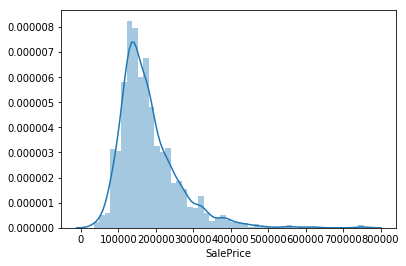

In [10]:
############################## ターゲットの分布

sns.distplot(df_train['SalePrice'])

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([ 34900,  35311,  37900, ..., 625000, 745000, 755000])),
 (74160.16474519415, 180921.19589041095, 0.9319665641512986))

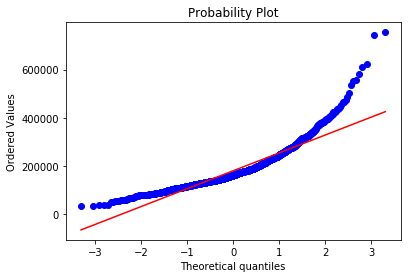

In [11]:
##############################  シャピロウィルク検定（W, p値）→　p値が0.05以下の場合は棄却

stats.probplot(df_train['SalePrice'], dist="norm", plot=pylab)
# 一直線に近いほど正規分布に従う

In [12]:
############################## 歪度(グラフがどれくらい平均の回りに対称に分布していないか) → 0に近いほど正規分布に近い

pd.Series(df_train['SalePrice']).skew()

1.8828757597682129

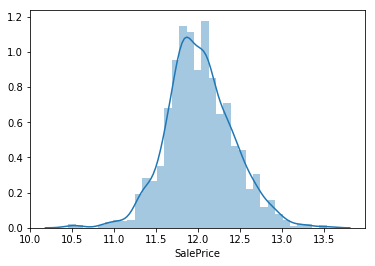

In [13]:
############################## logで「対数正規分布化」----対数正規分布にしたがう「変数の対数」をとって正規分布に従う変数を作る

# skewなデータ
# https://atarimae.biz/archives/13161

y_train_log = np.log(df_train['SalePrice']) 
sns.distplot(y_train_log)

# np.log(df_train['SalePrice'])  =  np.log.e(df_train['SalePrice']) → eを何乗すればdf_train['SalePrice']になるかという意味
# np.e=2.718281828459045(numpyの定義)
# 正規分布に変換

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([10.46024211, 10.47194981, 10.54270639, ..., 13.34550693,
         13.5211395 , 13.53447303])),
 (0.3982622308161886, 12.024050901109383, 0.9953761475636613))

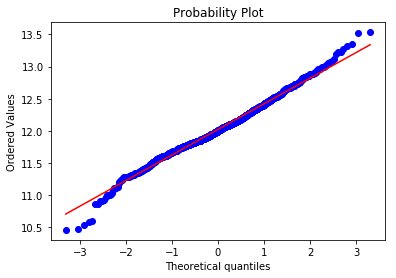

In [14]:
stats.probplot(y_train_log, dist="norm", plot=pylab)

In [15]:
############################## 歪度

pd.Series(y_train_log).skew()

0.12133506220520406

### Data Explore ---correlation

In [16]:
train_id = df_train['Id']
test_id = df_test['Id']
y_train_ = df_train['SalePrice'].copy()

combine = [df_train, df_test]

for dataset in combine:
    dataset.drop('Id',axis=1,inplace=True)

print(df_train.shape, df_test.shape, y_train_.shape)

(1460, 80) (1459, 79) (1460,)


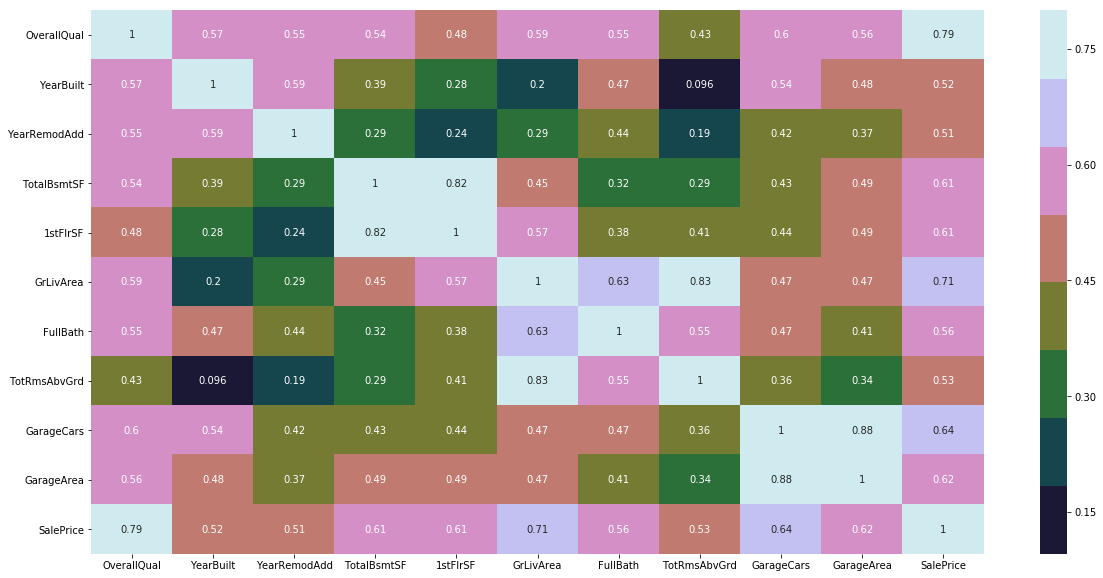

In [17]:
top_features = df_train.corr().index[abs(df_train.corr()['SalePrice'] > 0.5)]
plt.figure(figsize=(20,10))
pal = sns.color_palette("cubehelix", 8)
sns.heatmap(df_train[top_features].corr(),vmax=0.8,annot=True,cmap=pal)

In [18]:
new_top_features = ['SalePrice','OverallQual','YearBuilt','TotalBsmtSF','GrLivArea','FullBath',\
                    'GarageCars','1stFlrSF','GarageArea','TotRmsAbvGrd']

### Concatenation of train and test data

In [19]:
ntrain = df_train.shape[0]
ntest = df_test.shape[0]

all_data = pd.concat([df_train,df_test]).reset_index(drop=True)
all_data.drop(['SalePrice'],axis=1,inplace=True)
all_data.shape

/Users/yoshiko/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


(2919, 79)

In [20]:
############################## NaN値合計

all_data.isnull().values.sum() # 7000

############################## バリュー数合計

all_data.size # 230443

############################## NaN値の割合

all_data.isnull().values.sum()/all_data.size # 約3%がNaN値

############################## オブジェクトデータ

all_data.describe(include=['O'])


,Alley,BldgType,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual,CentralAir,Condition1,Condition2,...,MiscFeature,Neighborhood,PavedDrive,PoolQC,RoofMatl,RoofStyle,SaleCondition,SaleType,Street,Utilities
count,198,2919,2837,2837,2840,2839,2838,2919,2919,2919,...,105,2919,2919,10,2919,2919,2919,2918,2919,2917
unique,2,5,4,4,6,6,4,2,9,8,...,4,25,3,3,8,6,6,9,2,2
top,Grvl,1Fam,TA,No,Unf,Unf,TA,Y,Norm,Norm,...,Shed,NAmes,Y,Ex,CompShg,Gable,Normal,WD,Pave,AllPub
freq,120,2425,2606,1904,851,2493,1283,2723,2511,2889,...,95,443,2641,4,2876,2310,2402,2525,2907,2916


In [21]:
############################## object型データ　→　int型データ

categorical_feats = [
    f for f in all_data.columns if all_data[f].dtype == 'object'
]
categorical_feats_ = categorical_feats.copy()# 43


for f in categorical_feats_:
    all_data[f], _ = pd.factorize(all_data[f])
    all_data[f] = all_data[f].astype('int')
    
print(all_data[categorical_feats_].isnull().values.sum()!=0)

all_data.head()

False


,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,-1,3,0,0,0,706.0,0.0,...,0,0,0,8,856.0,0,0,2003,2003,2008
1,1262,0,0,-1,3,0,0,1,978.0,0.0,...,0,0,0,6,1262.0,0,298,1976,1976,2007
2,920,866,0,-1,3,0,0,2,486.0,0.0,...,0,0,0,6,920.0,0,0,2001,2002,2008
3,961,756,0,-1,3,0,1,0,216.0,0.0,...,0,0,0,7,756.0,0,0,1915,1970,2006
4,1145,1053,0,-1,4,0,0,3,655.0,0.0,...,0,0,0,9,1145.0,0,192,2000,2000,2008


In [22]:
all_data['Alley'][0]

-1

In [23]:
# factorizeでNaNから変換された-1を平均値で置き換える

for c in all_data.columns:
    for i in range(all_data.shape[1]):
        if all_data[c][i] == -1:
            all_data[c][i] = all_data[c].mean()
            
all_data.head()

/Users/yoshiko/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,0,3,0,0,0,706.0,0.0,...,0,0,0,8,856.0,0,0,2003,2003,2008
1,1262,0,0,0,3,0,0,1,978.0,0.0,...,0,0,0,6,1262.0,0,298,1976,1976,2007
2,920,866,0,0,3,0,0,2,486.0,0.0,...,0,0,0,6,920.0,0,0,2001,2002,2008
3,961,756,0,0,3,0,1,0,216.0,0.0,...,0,0,0,7,756.0,0,0,1915,1970,2006
4,1145,1053,0,0,4,0,0,3,655.0,0.0,...,0,0,0,9,1145.0,0,192,2000,2000,2008


In [24]:
############################## 残りのfloat型 NaN値

null_feats = [
    n for n in all_data.columns if all_data[n].isnull().values.sum()!=0
]
null_feats

['BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtFullBath',
 'BsmtHalfBath',
 'BsmtUnfSF',
 'GarageArea',
 'GarageCars',
 'GarageYrBlt',
 'LotFrontage',
 'MasVnrArea',
 'TotalBsmtSF']

In [25]:
print(all_data['LotFrontage'].describe(),# 所有地に面した道路の幅
all_data['MasVnrArea'].describe(),# ベニヤ板の面積
all_data['GarageYrBlt'].describe()) # ガレージの築年数

count    2433.000000
mean       69.305795
std        23.344905
min        21.000000
25%        59.000000
50%        68.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64 count    2896.000000
mean      102.201312
std       179.334253
min         0.000000
25%         0.000000
50%         0.000000
75%       164.000000
max      1600.000000
Name: MasVnrArea, dtype: float64 count    2760.000000
mean     1978.113406
std        25.574285
min      1895.000000
25%      1960.000000
50%      1979.000000
75%      2002.000000
max      2207.000000
Name: GarageYrBlt, dtype: float64


In [26]:
############################## "Neighborhood"ごとの"LotFrontage"の平均値で埋める

f = lambda x: x.fillna(x.mean()) #平均値
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(f)

############################## 'MasVnrArea'、'GarageYrBlt'を欠損値を0で埋める

all_data['MasVnrArea'].fillna(all_data['MasVnrArea'].mean(), inplace=True)
all_data['GarageYrBlt'].fillna(all_data['GarageYrBlt'].mean(), inplace=True)
all_data.isnull().values.sum()!=0

True

In [27]:
############################## 時系列データをlabelencorderする 例:1980→80

lab = LabelEncoder()
all_data["YearBuilt"] = lab.fit_transform(all_data["YearBuilt"])
all_data["YearRemodAdd"] = lab.fit_transform(all_data["YearRemodAdd"])
all_data["GarageYrBlt"] = lab.fit_transform(all_data["GarageYrBlt"])

In [28]:
############################## feature engineeringが完了したのでtrainとtestに分ける

df_train = all_data[:ntrain]
df_test = all_data[ntrain:]

## Analyze, identify patterns, and explore the data

### feature importanceの比較

In [29]:
############################## featureとTargetの相関----Random Forest

from sklearn.ensemble import RandomForestRegressor

train_features = [f for f in df_train if f not in ['Id','SalePrice']]
y = y_train_.copy()

feat_labels = df_train.columns[0:]
forest = RandomForestRegressor(n_estimators=1000, random_state=0, n_jobs=-1)
forest.fit(df_train[train_features], y)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(df_train[train_features].shape[1]):
    print("%2d) %-*s %f" %
          (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

 1) OverallQual                    0.584517
 2) GrLivArea                      0.108636
 3) TotalBsmtSF                    0.040225
 4) 2ndFlrSF                       0.034910
 5) BsmtFinSF1                     0.027884
 6) 1stFlrSF                       0.024307
 7) GarageCars                     0.019815
 8) GarageArea                     0.015882
 9) LotArea                        0.013187
10) YearBuilt                      0.009850
11) LotFrontage                    0.007866
12) TotRmsAbvGrd                   0.007844
13) YearRemodAdd                   0.007287
14) FullBath                       0.005577
15) MasVnrArea                     0.005550
16) BsmtUnfSF                      0.005180
17) OpenPorchSF                    0.005014
18) WoodDeckSF                     0.004604
19) GarageYrBlt                    0.004378
20) OverallCond                    0.004315
21) Neighborhood                   0.004239
22) BsmtQual                       0.004129
23) MoSold                      

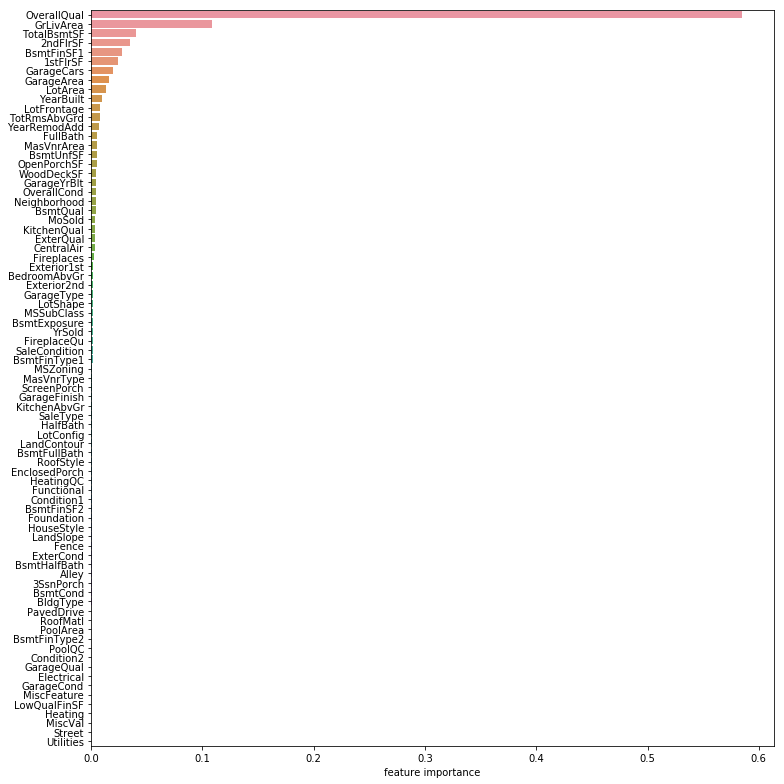

In [30]:
############################## RandomForest_feature_importanceプロット

ranking = np.argsort(-forest.feature_importances_)# np.argsort()の引数の頭に"-"をつけると降順にソートされる。
f, ax = plt.subplots(figsize=(11, 11)) 
sns.barplot(x=forest.feature_importances_[ranking], y=df_train[train_features].columns.values[ranking], orient='h')
ax.set_xlabel("feature importance")
plt.tight_layout()
plt.show()

In [40]:
############################## featureとTargetの相関----lightGBM

lgbm_params = {'objective':'regression',
            'num_leaves':5,
            'learning_rate':0.05, 
            'n_estimators':720,
            'max_bin': 55, 
            'bagging_fraction': 0.8,
            'bagging_freq' :5, 
            'feature_fraction':0.2319,
            'feature_fraction_seed':9, 
            'bagging_seed':9,
            'min_data_in_leaf':6, 
            'min_sum_hessian_in_leaf':11}


train_features = [f for f in df_train if f not in ['Id', 'SalePrice']]
y = y_train_.copy()

X_train, X_test, y_train, y_test = train_test_split(df_train[train_features], y, random_state=42)
lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False, silent=True)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
model = lgb.train(lgbm_params, lgb_train, valid_sets=lgb_eval, num_boost_round=40)
importances_lgbm = model.feature_importance()
indices = np.argsort(importances_lgbm)[::-1]
for f in range(df_train[train_features].shape[1]):
    print("%2d) %-*s %f" %
          (f + 1, 30, feat_labels[indices[f]], importances_lgbm[indices[f]]))

[1]	valid_0's l2: 6.57793e+09
[2]	valid_0's l2: 6.23693e+09
[3]	valid_0's l2: 5.89207e+09
[4]	valid_0's l2: 5.58634e+09
[5]	valid_0's l2: 5.32146e+09
[6]	valid_0's l2: 5.06658e+09
[7]	valid_0's l2: 4.83314e+09
[8]	valid_0's l2: 4.59477e+09
[9]	valid_0's l2: 4.38105e+09
[10]	valid_0's l2: 4.19965e+09
[11]	valid_0's l2: 3.97921e+09
[12]	valid_0's l2: 3.80686e+09
[13]	valid_0's l2: 3.67131e+09
[14]	valid_0's l2: 3.5368e+09
[15]	valid_0's l2: 3.39557e+09
[16]	valid_0's l2: 3.26603e+09
[17]	valid_0's l2: 3.15527e+09
[18]	valid_0's l2: 3.07856e+09
[19]	valid_0's l2: 2.97198e+09
[20]	valid_0's l2: 2.85029e+09
[21]	valid_0's l2: 2.73445e+09
[22]	valid_0's l2: 2.62929e+09
[23]	valid_0's l2: 2.54234e+09
[24]	valid_0's l2: 2.45886e+09
[25]	valid_0's l2: 2.38543e+09
[26]	valid_0's l2: 2.31791e+09
[27]	valid_0's l2: 2.255e+09
[28]	valid_0's l2: 2.18919e+09
[29]	valid_0's l2: 2.11866e+09
[30]	valid_0's l2: 2.0467e+09
[31]	valid_0's l2: 1.99495e+09
[32]	valid_0's l2: 1.92603e+09
[33]	valid_0's l2: 1.

In [41]:
importances_lgbm

array([121,  95,  19,  11,  30,   5,  13,  29, 121,  18,  15,   2,  16,
         1,  21,  42,   8,  51,   0,   2,  10,   2,  28,  57,  43,   6,
        42,  47,  13,  23,  30, 126,  22,   3,  12,   9,  12,  69, 149,
         9,   1,   8,  19,  12,  18,  53,   6, 135,  21, 106,  15,   3,
        22,  19,  77,  14,   0,   0,  65, 115, 125,  62,  77,   4,   0,
         6,  21,  20,  58,  18,  27,   0,  65, 151,   0,  52,  80,  54,
        19])

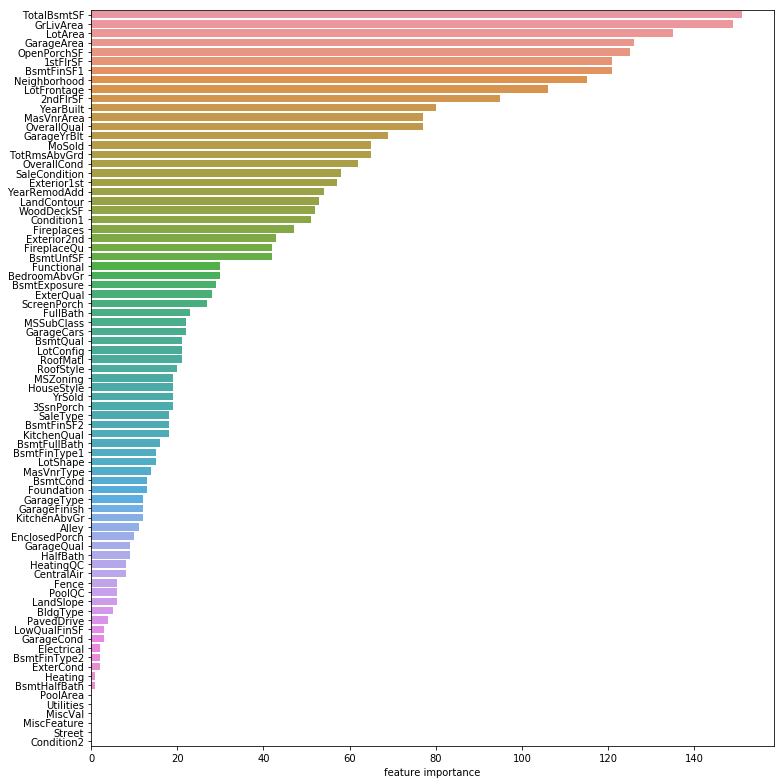

In [32]:
############################## lgbm_feature_importanceプロット

ranking = np.argsort(-importances_lgbm)
f, ax = plt.subplots(figsize=(11, 11)) 
sns.barplot(x=importances_lgbm[ranking], y=df_train[train_features].columns.values[ranking], orient='h')
ax.set_xlabel("feature importance")
plt.tight_layout()
plt.show()

In [33]:
############################## featureとTargetの相関----XGBoost

model_xgb = xgb.XGBRegressor(colsample_bytree=0.2, 
            gamma=0.0, 
            learning_rate=0.05, 
            max_depth=6,
            min_child_weight=1.5, 
            n_estimators=7200,
            reg_alpha=0.9, 
            reg_lambda=0.6,
            subsample=0.2, 
            silent=1)

feat_labels = df_train.columns[0:]
train_features = [f for f in df_train if f not in ['Id', 'SalePrice']]
y = y_train_.copy()

#X_train, X_test, y_train, y_test = train_test_split(df_train[train_features], y, random_state=42)
model_xgb.fit(df_train[train_features], y)
importances_xgb = model_xgb.feature_importances_
indices = np.argsort(importances_xgb)[::-1]
for f in range(df_train[train_features].shape[1]):
    print("%2d) %-*s %f" %
          (f + 1, 30, feat_labels[indices[f]], importances_xgb[indices[f]]))

 1) 1stFlrSF                       0.052906
 2) LotArea                        0.047869
 3) BsmtUnfSF                      0.046334
 4) GrLivArea                      0.043948
 5) GarageArea                     0.043005
 6) TotalBsmtSF                    0.039800
 7) GarageYrBlt                    0.037263
 8) BsmtFinSF1                     0.036872
 9) LotFrontage                    0.036167
10) YearBuilt                      0.031699
11) OpenPorchSF                    0.029167
12) MasVnrArea                     0.027920
13) YearRemodAdd                   0.027801
14) 2ndFlrSF                       0.027074
15) MoSold                         0.026770
16) WoodDeckSF                     0.025203
17) Neighborhood                   0.021993
18) TotRmsAbvGrd                   0.017650
19) Exterior1st                    0.017563
20) Exterior2nd                    0.017254
21) YrSold                         0.016744
22) BsmtFinType1                   0.015654
23) MSSubClass                  

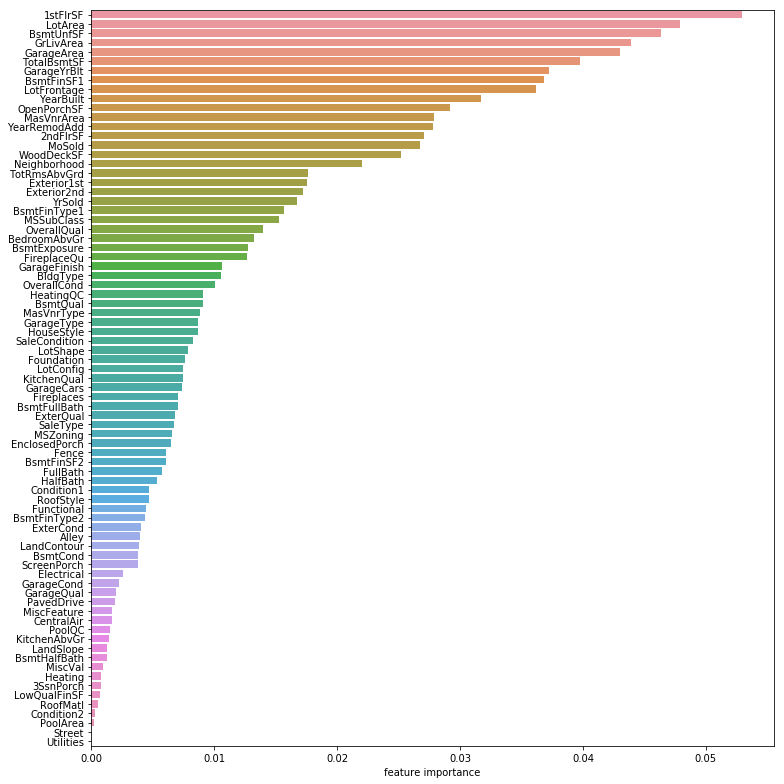

In [34]:
############################## xgb_feature_importanceプロット

ranking = np.argsort(-importances_xgb)
f, ax = plt.subplots(figsize=(11, 11)) 
sns.barplot(x=importances_xgb[ranking], y=df_train[train_features].columns.values[ranking], orient='h')
ax.set_xlabel("feature importance")
plt.tight_layout()
plt.show()

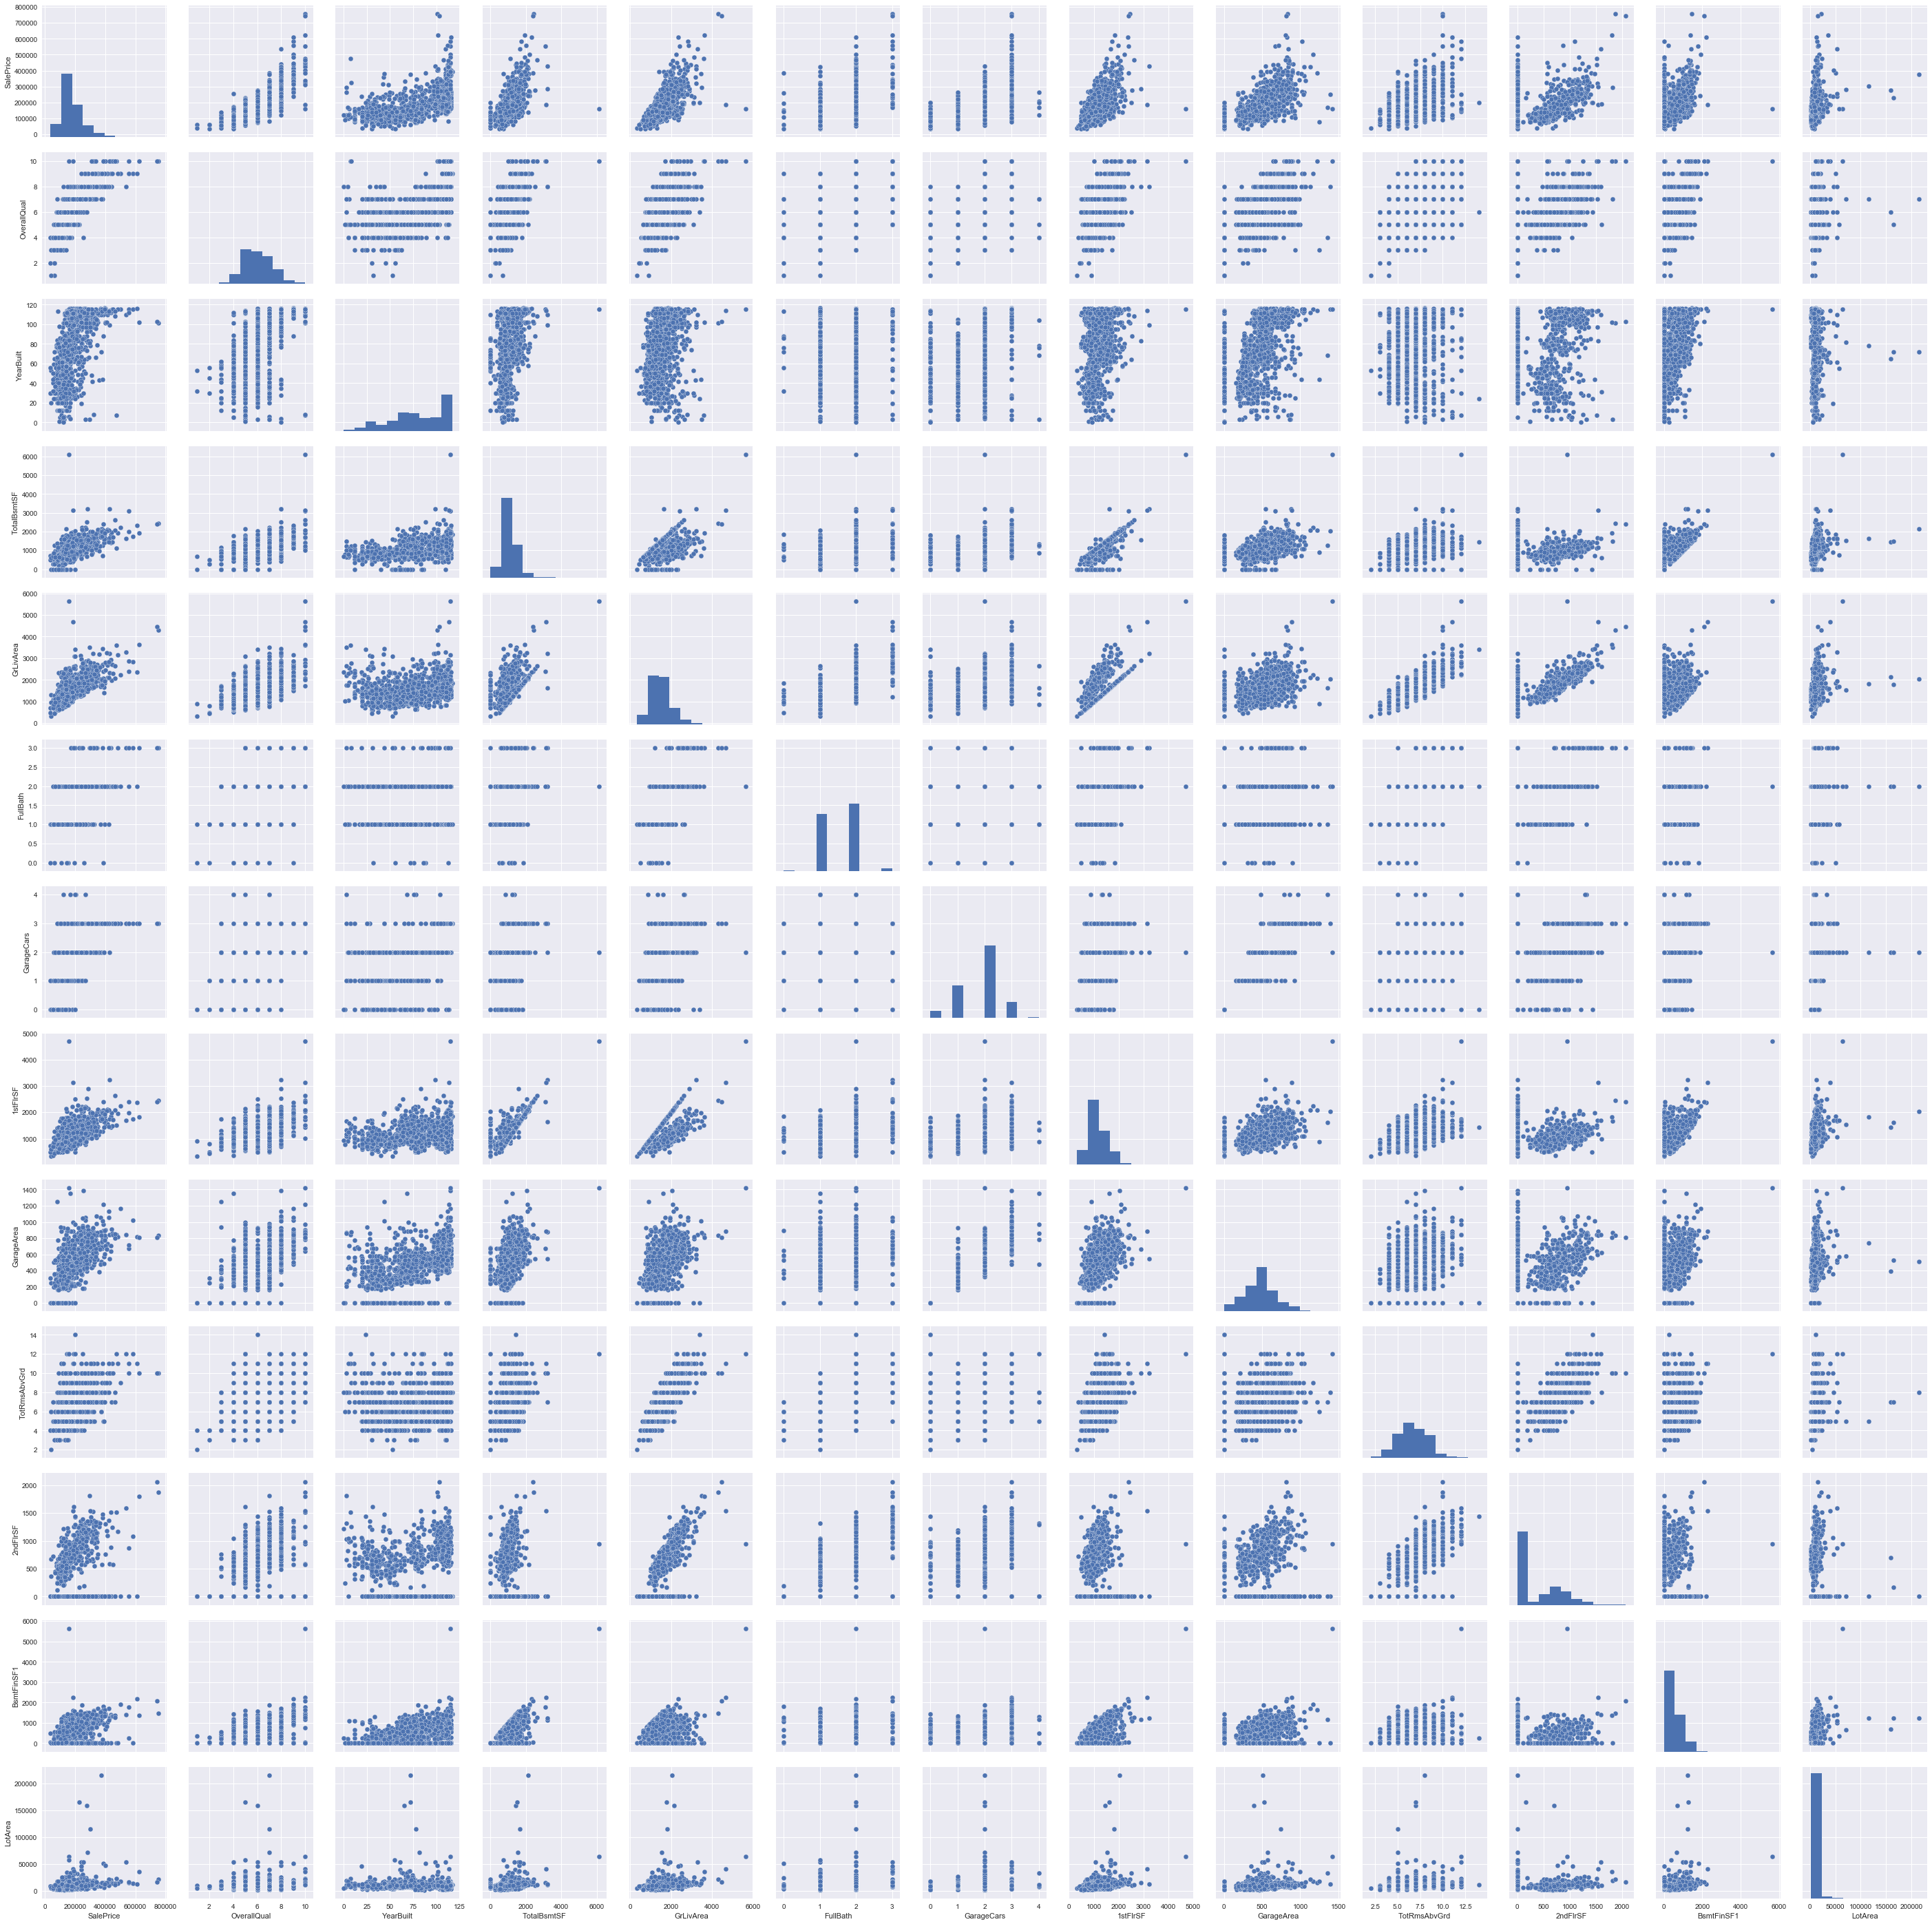

In [35]:
############################## 以前、ヒートマップで出したnew_top_featuresに直近のfeature_importanceの上位特徴量を加える

new_top_features.extend(['2ndFlrSF','BsmtFinSF1','LotArea'])

df = pd.concat([df_train, y_train_], axis=1) #new_top_featuresにTargetカラムも含まれるので、Xとyのデータセットを一時的に作成
df

sns.set()
sns.pairplot(df[new_top_features],size=3) #df_tarinでなくtrainデータ
plt.show()

(0, 800000)

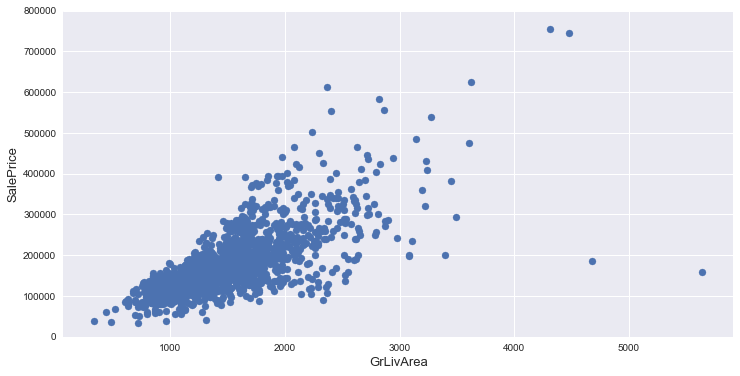

In [36]:
############################## 外れ値(outlier)のチェック

plt.figure(figsize=(12,6))
plt.scatter(x=df_train.GrLivArea, y=y_train_)
plt.xlabel("GrLivArea", fontsize=13)
plt.ylabel("SalePrice", fontsize=13)
plt.ylim(0,800000)

(0, 800000)

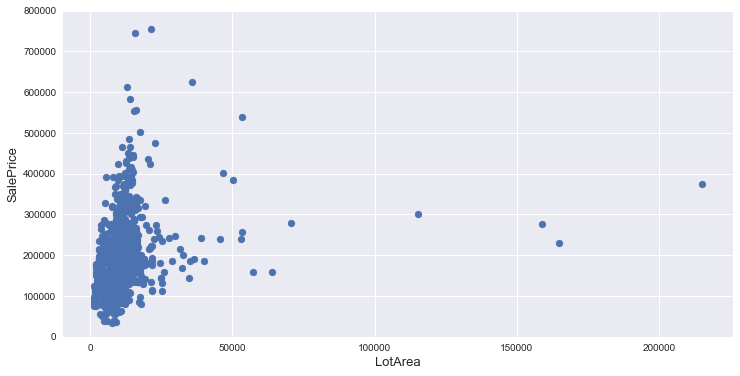

In [37]:
plt.figure(figsize=(12,6))
plt.scatter(x=df_train.LotArea, y=y_train_)
plt.xlabel("LotArea", fontsize=13)
plt.ylabel("SalePrice", fontsize=13)
plt.ylim(0,800000)

In [38]:
############################## 外れ値のカウント（全体に対して個々の特徴量のうちの外れ値を示してくれる）

from sklearn.ensemble import IsolationForest

IsolationForest(bootstrap=False, contamination=0.01, max_features=1.0,
        max_samples='auto', n_estimators=500, n_jobs=1, random_state=1234,
        verbose=0)

clf = IsolationForest(random_state=1234,n_estimators=500, contamination=0.01, max_features=1.0)
clf.fit(df_train)

mv_outliers = pd.DataFrame(clf.predict(df_train))
mv_outliers.columns = ['OutlierFlag']

mv_outliers[mv_outliers == -1].count()

OutlierFlag    15
dtype: int64

In [36]:
mv_outliers['OutlierFlag'].value_counts()

 1    1445
-1      15
Name: OutlierFlag, dtype: int64

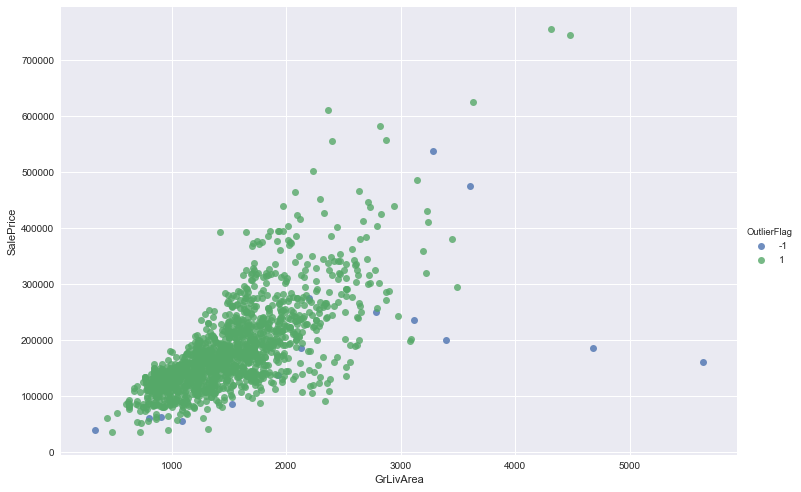

In [37]:
df_all_olcheck = pd.concat([mv_outliers, df_train, y_train_], axis=1)
ax = sns.lmplot(x='GrLivArea', y='SalePrice',fit_reg=False,
                data=df_all_olcheck, hue='OutlierFlag', size=7, aspect=1.5)

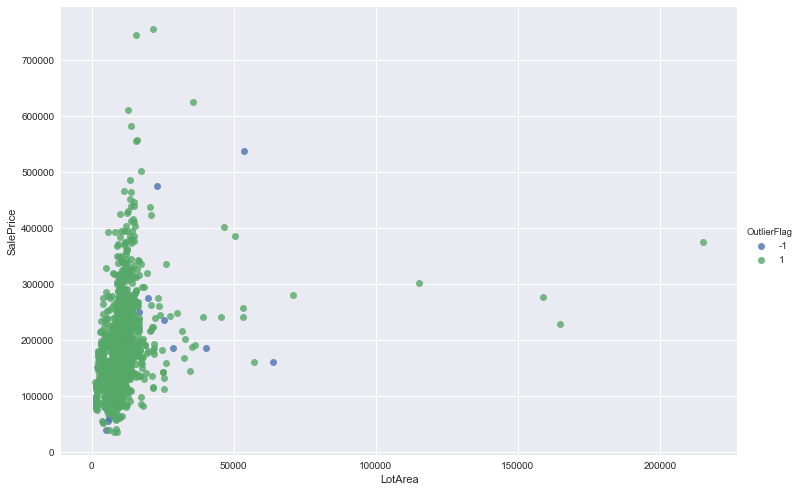

In [38]:
ax = sns.lmplot(x='LotArea', y='SalePrice',fit_reg=False,
                data=df_all_olcheck, hue='OutlierFlag', size=7, aspect=1.5)

In [39]:
############################## 外れ値の削除

#df_train = df_train.drop(df_train[(df_train['GrLivArea'] > 4000) & (train['SalePrice'] < 300000)].index)

In [40]:
############################## 歪度が0.75以上のものを対数変換

numerical_var = all_data.dtypes[all_data.dtypes != 'object'].index

skewed_feats = all_data[numerical_var].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew':skewed_feats})
skewness.head(10)

,Skew
MiscVal,21.947195
PoolArea,16.898328
Street,15.500133
LotArea,12.822431
Condition2,12.233664
LowQualFinSF,12.088761
Heating,11.985565
3SsnPorch,11.376065
RoofMatl,9.377305
PoolQC,7.635757


In [41]:
skewness = skewness[abs(skewness) > 0.75]

In [42]:
from scipy.special import boxcox1p

skewed_feats = skewness.index
lam = 0.15
for feat in skewed_feats:
    all_data[feat] = boxcox1p(all_data[feat],lam)

In [43]:
all_data

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,11.692623,11.686189,0.000000,0.000000,1.540963,0.000000,0.000000,0.000000,11.170327,0.000000,...,0.000000,0.000000,0.000000,2.602594,11.692623,0.0,0.000000,6.844946,5.460736,14.195323
1,12.792276,0.000000,0.000000,0.000000,1.540963,0.000000,0.000000,0.730463,12.062832,0.000000,...,0.000000,0.000000,0.000000,2.259674,12.792276,0.0,9.010206,6.291711,4.263161,14.193765
2,11.892039,11.724598,0.000000,0.000000,1.540963,0.000000,0.000000,1.194318,10.200343,0.000000,...,0.000000,0.000000,0.000000,2.259674,11.892039,0.0,0.000000,6.808145,5.426781,14.195323
3,12.013683,11.354094,0.000000,0.000000,1.540963,0.000000,0.730463,0.000000,8.274266,0.000000,...,0.000000,0.000000,0.000000,2.440268,11.354094,0.0,0.000000,4.201461,3.858807,14.192207
4,12.510588,12.271365,0.000000,0.000000,1.820334,0.000000,0.000000,1.540963,10.971129,0.000000,...,0.000000,0.000000,0.000000,2.750250,12.510588,0.0,8.013884,6.789529,5.357203,14.195323
5,11.493820,10.589574,9.178051,0.000000,0.730463,0.000000,0.000000,0.000000,11.267217,0.000000,...,0.000000,0.000000,0.000000,2.055642,11.493820,0.0,4.969939,6.654950,5.172535,14.196881
6,13.670207,0.000000,0.000000,0.000000,1.540963,0.000000,0.000000,1.540963,13.031093,0.000000,...,0.000000,0.000000,0.000000,2.440268,13.655781,0.0,8.649311,6.863135,5.527074,14.193765
7,12.413831,12.077149,0.000000,0.000000,1.540963,0.000000,0.000000,1.194318,11.702249,4.597157,...,0.000000,0.000000,0.000000,2.440268,12.413831,0.0,8.463564,6.221214,4.071754,14.196881
8,12.186751,11.339779,0.000000,0.000000,1.194318,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,2.602594,11.987364,0.0,6.448232,5.012077,0.000000,14.195323
9,12.335431,0.000000,0.000000,0.000000,1.194318,0.730463,0.000000,0.000000,11.676516,0.000000,...,0.000000,0.000000,0.000000,2.055642,12.099929,0.0,0.000000,5.285266,0.000000,14.195323


In [44]:
############################## 再びトレインとテストに分ける

df_train = all_data[:ntrain]
df_test = all_data[ntrain:]

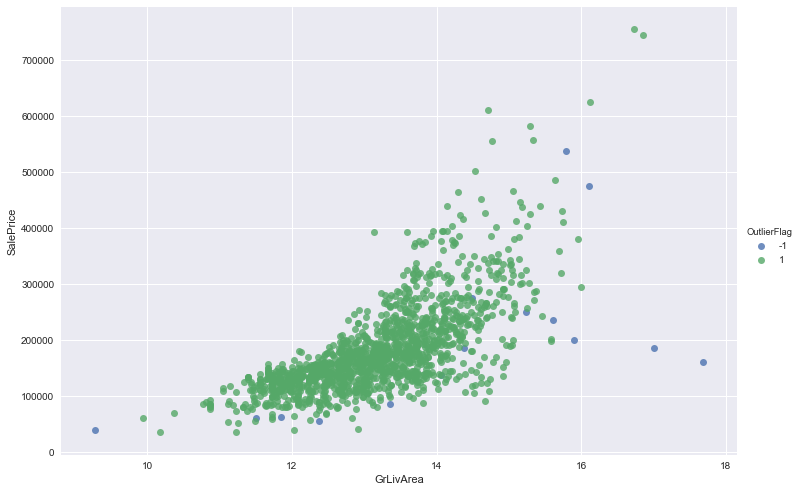

In [45]:
df_all_olcheck = pd.concat([mv_outliers, df_train, y_train_], axis=1)
ax = sns.lmplot(x='GrLivArea', y='SalePrice',fit_reg=False,
                data=df_all_olcheck, hue='OutlierFlag', size=7, aspect=1.5)

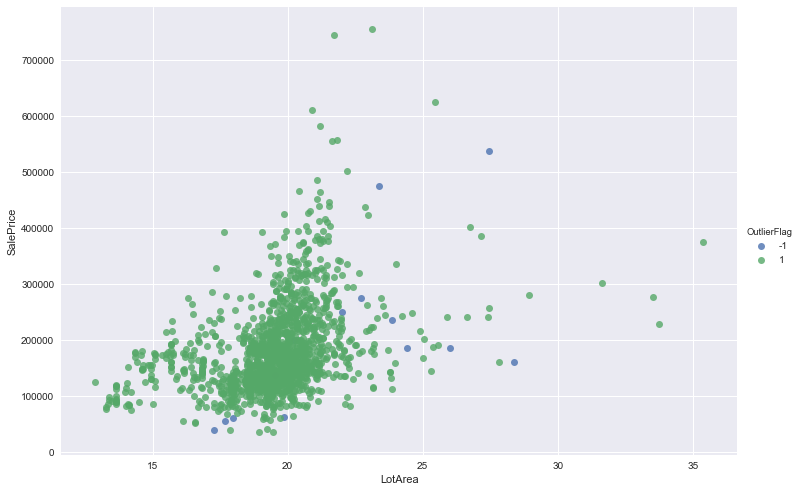

In [46]:
ax = sns.lmplot(x='LotArea', y='SalePrice',fit_reg=False,
                data=df_all_olcheck, hue='OutlierFlag', size=7, aspect=1.5)

In [47]:
############################## IsolationForestのパラメータチューニング

from sklearn.ensemble import IsolationForest
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer,f1_score
from sklearn.grid_search import GridSearchCV

# Grid Search over contamination fraction

forest = IsolationForest()
forest.fit(df_train)
outliers = pd.DataFrame(forest.predict(df_train))
outliers.columns = ['OutlierFlag']

skf = StratifiedKFold(n_splits=3) 
folds = list(skf.split(df_train, outliers))

forest.contamination = sum(outliers['OutlierFlag']==-1)/len(outliers['OutlierFlag'])
f1sc = make_scorer(f1_score)
ps = {'n_estimators': (50, 100, 500, 1000),'contamination': (0.1,0.05,0.01), 'max_samples': (5,10,50,100)}
search = GridSearchCV(estimator=forest, param_grid=ps, scoring=f1sc, cv=folds)
search.fit(df_train, outliers)

/Users/yoshiko/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/yoshiko/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


GridSearchCV(cv=[(array([ 386,  392, ..., 1458, 1459]), array([  0,   1, ..., 493, 494])), (array([   0,    1, ..., 1458, 1459]), array([386, 392, ..., 975, 976])), (array([  0,   1, ..., 975, 976]), array([ 944,  954, ..., 1458, 1459]))],
       error_score='raise',
       estimator=IsolationForest(bootstrap=False, contamination=0.1, max_features=1.0,
        max_samples='auto', n_estimators=100, n_jobs=1, random_state=None,
        verbose=0),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': (50, 100, 500, 1000), 'contamination': (0.1, 0.05, 0.01), 'max_samples': (5, 10, 50, 100)},
       pre_dispatch='2*n_jobs', refit=True, scoring=make_scorer(f1_score),
       verbose=0)

In [48]:
df = pd.DataFrame(search.grid_scores_)
df[['parameters','mean_validation_score']].sort_values(by=["mean_validation_score"],ascending=False).head(10)

,parameters,mean_validation_score
14,"{'contamination': 0.1, 'max_samples': 100, 'n_...",0.982130
15,"{'contamination': 0.1, 'max_samples': 100, 'n_...",0.980597
10,"{'contamination': 0.1, 'max_samples': 50, 'n_e...",0.977934
13,"{'contamination': 0.1, 'max_samples': 100, 'n_...",0.976425
11,"{'contamination': 0.1, 'max_samples': 50, 'n_e...",0.976055
9,"{'contamination': 0.1, 'max_samples': 50, 'n_e...",0.973421
30,"{'contamination': 0.05, 'max_samples': 100, 'n...",0.972965
31,"{'contamination': 0.05, 'max_samples': 100, 'n...",0.972623
29,"{'contamination': 0.05, 'max_samples': 100, 'n...",0.971806
27,"{'contamination': 0.05, 'max_samples': 50, 'n_...",0.971526


In [49]:
outliers = pd.DataFrame(forest.predict(df_train))
outliers[0].value_counts()

 1    1314
-1     146
Name: 0, dtype: int64

In [50]:
# enc = OneHotEncoder()
# df = DataFrame(enc.fit_transform(df).toarray())

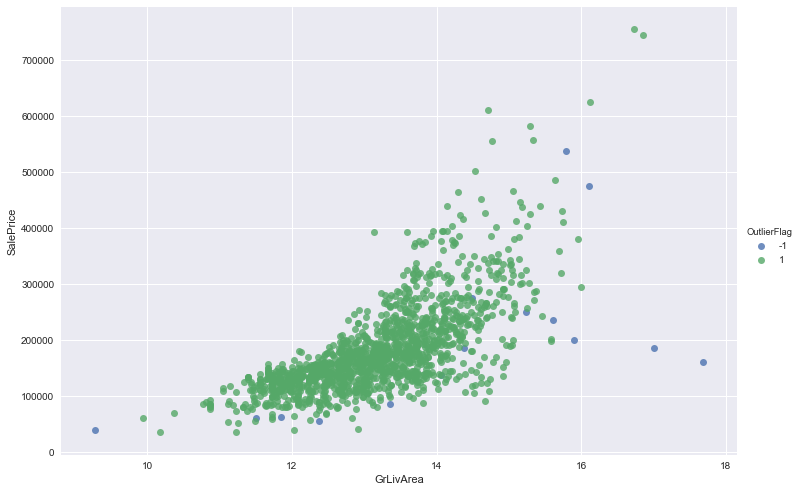

In [51]:
df_all_olcheck = pd.concat([mv_outliers, df_train, y_train_], axis=1)
ax = sns.lmplot(x='GrLivArea', y='SalePrice',fit_reg=False,
                data=df_all_olcheck, hue='OutlierFlag', size=7, aspect=1.5)

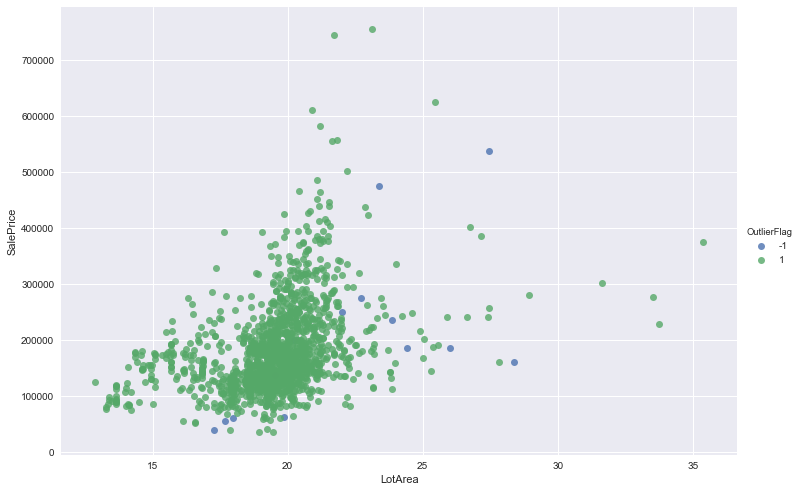

In [52]:
ax = sns.lmplot(x='LotArea', y='SalePrice',fit_reg=False,
                data=df_all_olcheck, hue='OutlierFlag', size=7, aspect=1.5)

In [53]:
optimal_forest = search.best_estimator_
pred = optimal_forest.predict(df_train)

In [62]:
outliers[0].value_counts()

 1    1314
-1     146
Name: 0, dtype: int64

In [61]:
pd.DataFrame(pred)[0].value_counts()

 1    1314
-1     146
Name: 0, dtype: int64

No handles with labels found to put in legend.


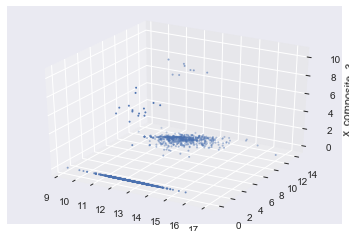

In [64]:
# Plot all the reduced-dimensionality ground truth points together with the predictions
from mpl_toolkits.mplot3d import Axes3D
#import snips as snp

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#snp.labs("x_composite_1", "x_composite_2", "Outliers in Reduced Dimension")
ax.set_zlabel("x_composite_3")

# Plot the reduced dimensionality data points
ax.scatter(df_train.iloc[:, 0], df_train.iloc[:, 1], zs=df_train.iloc[:, 2], s=4, lw=0)

# Plot circles around the predicted outliers
#ax.scatter(df_train[pred==-1, 0], df_train[pred==-1, 1], zs=df_train[pred==-1, 2], 
#           lw=2, facecolors="none", edgecolors="r", s=80, label="predicted outlier")

# Plot x's for the ground truth outliers
#ax.scatter(df_train[outliers==-1, 0], df_train[outliers==-1, 1], zs=df_train[outliers==-1, 2], 
#           lw=2, s=60, marker="x", c="red", label="outlier")
ax.legend()

## Model, predict and solve the problem